In [50]:
import pandas as pd
import numpy as np
import os
import timeit
from tqdm.notebook import trange, tqdm
import re
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [51]:
DEMO = True
WRITE_ERRORS_TO_FILE = False

In [52]:

if DEMO:
    CHARTEVENTS_BY_ICUSTAY_ID = 'data_demo/parquet/'
    REDUCED_CE_BY_ICUSTAY_ID = 'data_demo/samples/'
    NUMERICAL_BY_ICUSTAY_ID = 'data_demo/samples_numerical/'
    STATB_BY_ICUSTAY_ID = 'data_demo/samples_statB/'
    STATB_CSV_BY_ICUSTAY_ID = 'data_demo/samples_statB_csv/'
else:
    CHARTEVENTS_BY_ICUSTAY_ID = 'data/parquet/'
    REDUCED_CE_BY_ICUSTAY_ID = 'data/samples/'
    NUMERICAL_BY_ICUSTAY_ID = 'data/samples_numerical/'
    STATB_BY_ICUSTAY_ID = 'data/samples_statB/'


CHARTEVENTS_FILENAME = 'mimic-iii/CHARTEVENTS.csv'
READMISSION_FILENAME = 'data/readmission.csv'
PARQUET_EXT = '.parquet'
STEP_FAIL_FILE = 'Step6_failed.txt'
SLOPE_TEXT = '_A'
INTERCEPT_TEXT = '_B'

In [53]:
# chartevents_dir_list = os.listdir(REDUCED_CE_BY_ICUSTAY_ID)
# len(chartevents_dir_list)

In [54]:
# test = pd.read_parquet(REDUCED_CE_BY_ICUSTAY_ID + chartevents_dir_list[5])
# test = test.reset_index(drop=True)


![Glascow](assets/images/GCS.jpg)

https://www.firstaidforfree.com/glasgow-coma-scale-gcs-first-aiders/

|	Chart Event	|	Dim	|	Normal	| Initial dtype | Change to dtype |
| --- | :--- | :--- | :--- | :--- |
|	1. Glasgow coma scale eye opening	|	4	|	4 Spontaneously	| str | int |
|	2. Glasgow coma scale verbal response	|	5	|	5 Oriented	| str | int |
|	3. Glasgow coma scale motor response	|	6	|	6 Obeys Commands	| str | int |
|	4. Glasgow coma scale total	|	13	|	15	| none/int | int |
|	5. Capillary refill rate	|	2	|	Normal < 3 secs	| str | int |
|	6. Diastolic blood pressure	|	1	|	70	| int | int |
|	7. Systolic blood pressure	|	1	|	105	| int | int |
|	8. Mean blood pressure	|	1	|	87.5	| int/float | int |
|	9. Heart Rate	|	1	|	80	| int | int |
|	10. Glucose	|	1	|	85	| int | int |
|	11. Fraction inspired oxygen	|	1	|	0.21	| int/float | float? |
|	12. Oxygen saturation	|	1	|	97.5	| int | int |
|	13. Respiratory rate	|	1	|	15	| int | int |
|	14. Body Temperature	|	1	|	37	| float | float |
|	15. pH	|	1	|	7.4	| float | float |
|	16. Weight	|	1	|	80.7	| float | float |
|	17. Height	|	1	|	168.8	| float | float |


Since there are so many `NaN` values, everything should just be a float?

In [55]:
gcs_eye_map     = {'__missing__': np.NaN, '4 Spontaneously': '4', '1 No Response': '1', '2 To pain': '2', '3 To speech': '3', 'To Speech': '3', 'Spontaneously': '4', 'To Pain': '2'}
gcs_motor_map   = {'__missing__': np.NaN, '6 Obeys Commands': '6', '5 Localizes Pain': '5', '1 No Response': '1', '4 Flex-withdraws': '4', '2 Abnorm extensn': '2', '3 Abnorm flexion': '3', 'Localizes Pain': '5', 
                    'Obeys Commands': '6', 'Flex-withdraws': '4', 'No response': '1', 'Abnormal Flexion': '3', 'Abnormal extension': '2'}
gcs_verbal_map  = {'__missing__': np.NaN, '5 Oriented': '5', '1.0 ET/Trach': '1', '4 Confused': '4', '2 Incomp sounds': '2', '1 No Response': '1', '3 Inapprop words': '3', 'No Response-ETT': '1', 
                    'Oriented': '5', 'No Response': '1', 'Confused': '4', 'Incomprehensible sounds': '2', 'Inappropriate Words': '3'}
capillary_map = {'__missing__': np.NaN, 'Brisk':'1', 'Delayed':'0', 'Comment':'0', 'Normal <3 secs':'1', 'Abnormal >3 secs':'0', 'Other/Remarks':'0', 'Normal <3 Seconds':'1', 'Abnormal >3 Seconds':'0'}


In [56]:
# sample_dtype_init = {'GCS_EYE': object, 'GCS_EYE_ID': np.float64, 'GCS_MOTOR': object, 'GCS_MOTOR_ID': np.float64, 
#                      'GCS_VERBAL': object, 'GCS_VERBAL_ID': np.float64, 'GCS_TOTAL': object, 'GCS_TOTAL_ID': np.float64, 
#                      'CAPILLARY_REFILL': object, 'CAPILLARY_REFILL_ID': np.float64, 'D_BLOOD_PRESSURE': object, 
#                      'D_BLOOD_PRESSURE_ID': np.float64, 'M_BLOOD_PRESSURE': object, 'M_BLOOD_PRESSURE_ID': np.float64, 
#                      'S_BLOOD_PRESSURE': object, 'S_BLOOD_PRESSURE_ID': np.float64, 'HEART_RATE': object, 'HEART_RATE_ID': np.float64, 
#                      'GLUCOSE': object, 'GLUCOSE_ID': np.float64, 'FRAC_OXYGEN': object, 'FRAC_OXYGEN_ID': object, 'O2_SAT': object, 
#                      'O2_SAT_ID': np.float64, 'RESP_RATE': object, 'RESP_RATE_ID': np.float64, 'BODY_TEMP': object, 'BODY_TEMP_ID': np.float64, 
#                      'PH': object, 'PH_ID': np.float64, 'WEIGHT': object, 'WEIGHT_ID': np.float64, 'HEIGHT': object, 'HEIGHT_ID': np.float64, 
#                      'GCS_EYE_IND': np.int8, 'GCS_MOTOR_IND': np.int8, 'GCS_VERBAL_IND': np.int8, 'GCS_TOTAL_IND': np.int8, 
#                      'CAPILLARY_REFILL_IND': np.int8, 'D_BLOOD_PRESSURE_IND': np.int8, 'M_BLOOD_PRESSURE_IND': np.int8, 'S_BLOOD_PRESSURE_IND': np.int8, 
#                      'HEART_RATE_IND': np.int8, 'GLUCOSE_IND': np.int8, 'FRAC_OXYGEN_IND': np.int8, 'O2_SAT_IND': np.int8, 'RESP_RATE_IND': np.int8, 
#                      'BODY_TEMP_IND': np.int8, 'PH_IND': np.int8, 'WEIGHT_IND': np.int8, 'HEIGHT_IND': np.int8}

In [57]:
sample_dtype_final = {'GCS_EYE': np.float64, 'GCS_MOTOR': np.float64, 'GCS_VERBAL': np.float64, 'GCS_TOTAL': np.float64,
                     'CAPILLARY_REFILL': np.float64, 'D_BLOOD_PRESSURE': np.float64, 'M_BLOOD_PRESSURE': np.float64, 
                     'S_BLOOD_PRESSURE': np.float64, 'HEART_RATE': np.float64, 'GLUCOSE': np.float64, 'FRAC_OXYGEN': np.float64, 'O2_SAT': np.float64, 
                     'RESP_RATE': np.float64, 'BODY_TEMP': np.float64, 'PH': np.float64, 'WEIGHT': np.float64, 'HEIGHT': np.float64,  
                     'GCS_EYE_IND': np.int8, 'GCS_MOTOR_IND': np.int8, 'GCS_VERBAL_IND': np.int8, 'GCS_TOTAL_IND': np.int8, 
                     'CAPILLARY_REFILL_IND': np.int8, 'D_BLOOD_PRESSURE_IND': np.int8, 'M_BLOOD_PRESSURE_IND': np.int8, 'S_BLOOD_PRESSURE_IND': np.int8, 
                     'HEART_RATE_IND': np.int8, 'GLUCOSE_IND': np.int8, 'FRAC_OXYGEN_IND': np.int8, 'O2_SAT_IND': np.int8, 'RESP_RATE_IND': np.int8, 
                     'BODY_TEMP_IND': np.int8, 'PH_IND': np.int8, 'WEIGHT_IND': np.int8, 'HEIGHT_IND': np.int8}


In [58]:
chartevents_dir_list = os.listdir(REDUCED_CE_BY_ICUSTAY_ID)
len(chartevents_dir_list)

6

In [59]:
# test = pd.read_parquet(REDUCED_CE_BY_ICUSTAY_ID + chartevents_dir_list[0])
# test.head(1)

In [60]:
numerical_columns   = ['D_BLOOD_PRESSURE', 'M_BLOOD_PRESSURE', 'S_BLOOD_PRESSURE', 'HEART_RATE', 'GLUCOSE', 'FRAC_OXYGEN', 'O2_SAT', 'RESP_RATE', 'BODY_TEMP', 'PH', 'WEIGHT', 'HEIGHT']
category_columns    = ['GCS_EYE', 'GCS_MOTOR',  'GCS_VERBAL', 'GCS_TOTAL', 'CAPILLARY_REFILL']

In [61]:
stat_columns = category_columns.copy()
for col in numerical_columns:
    stat_columns.append(col+SLOPE_TEXT)
    stat_columns.append(col+INTERCEPT_TEXT)
# stat_columns

### Goals

1. Transform columns to numerical values
2. Transform dtypes


### Question

Should this be done before duplicating last entry on stays less than 48 hours???
It messes with the linear regression and mean

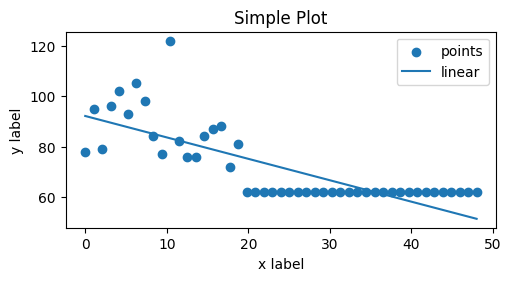

In [62]:
# Should this be done before duplicating last entry on stays less than 48 hours???
# It messes with the linear regression and mean
failed = []

for stay in tqdm(chartevents_dir_list, total=len(chartevents_dir_list)):
    # try:
        sample_df = pd.read_parquet(NUMERICAL_BY_ICUSTAY_ID + stay)
        sample_df = sample_df.reset_index(drop=True).astype(sample_dtype_final)
        stat_df = pd.DataFrame(columns=stat_columns)
        #numerical_df = sample_df[numerical_columns].dropna(axis=1,how='all')
        #bool_df = sample_df[numerical_columns].notnull()

        # Numerical Values (y = Ax + B). Store A and B
        bool_count = np.sum(sample_df[numerical_columns].notnull(), axis=0)
        numerical_df = sample_df[numerical_columns]
        for i, col in enumerate(numerical_df.columns):
            if sample_df[col].dtype == np.float64 and bool_count[i] > 1:
                # print(bool_count[i])
                feature_series = sample_df[col].dropna(ignore_index=True)
                if col == 'WEIGHT':
                     print(stay)
                     print(feature_series)
                # BUG:
                # BODY_TEMP IS 0.0 OR 1.0
                # PH IS 0.0 OR 1.0 
                x = np.array(list(range(len(feature_series)))).reshape(-1, 1)
                y = feature_series.to_numpy()
                reg = LinearRegression().fit(x, y)
                stat_df[col+SLOPE_TEXT] = reg.coef_ 
                stat_df[col+INTERCEPT_TEXT] = reg.intercept_

            elif sample_df[col].dtype == np.float64 and bool_count[i] == 1:
                # TODO: set single value as intercept, slope as 0
                pass

        # Categories (mean)
        bool_count = np.sum(sample_df[category_columns].notnull(), axis=0)
        category_df = sample_df[category_columns]
        for i, col in enumerate(category_df):
             if sample_df[col].dtype == np.float64 and bool_count[i] > 1:
                # print(bool_count[i])
                feature_series = sample_df[col].dropna(ignore_index=True)
                stat_df[col] = feature_series.mean()


        stat_df.to_parquet(STATB_BY_ICUSTAY_ID+stay)
        stat_df.to_csv(STATB_CSV_BY_ICUSTAY_ID+stay+'.csv')
        # break
    # except Exception as e:
    #     failed.append(stay)
    #     failed.append(str(e))
    #     continue


  0%|          | 0/6 [00:00<?, ?it/s]

ICUSTAY_ID=200003.parquet
0    78.699997
1    79.699997
Name: WEIGHT, dtype: float64
ICUSTAY_ID=200009.parquet
0    87.199997
1    92.099998
Name: WEIGHT, dtype: float64
ICUSTAY_ID=200010.parquet
0     49.3
1    108.5
Name: WEIGHT, dtype: float64


In [63]:
stat_df

,GCS_EYE,GCS_MOTOR,GCS_VERBAL,GCS_TOTAL,CAPILLARY_REFILL,D_BLOOD_PRESSURE_A,D_BLOOD_PRESSURE_B,M_BLOOD_PRESSURE_A,M_BLOOD_PRESSURE_B,S_BLOOD_PRESSURE_A,...,RESP_RATE_A,RESP_RATE_B,BODY_TEMP_A,BODY_TEMP_B,PH_A,PH_B,WEIGHT_A,WEIGHT_B,HEIGHT_A,HEIGHT_B
0,4.0,6.0,5.0,15.0,NaN,-0.849329,92.109043,-0.824931,102.12234,-0.742137,...,0.137158,12.339286,0.261111,36.177778,NaN,NaN,59.2,49.3,NaN,NaN


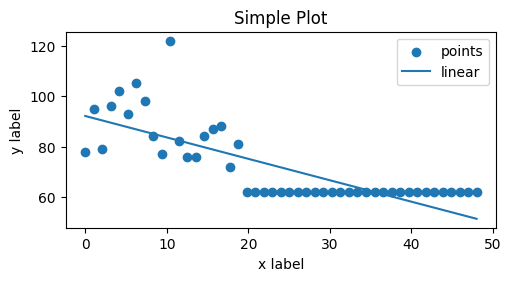

In [64]:


y_d_blood = numerical_df.loc[numerical_df['D_BLOOD_PRESSURE'].notnull(),'D_BLOOD_PRESSURE']
x = np.linspace(0,48,len(y_d_blood))
y = stat_df.loc[0,'D_BLOOD_PRESSURE_A'] * x + stat_df.loc[0,'D_BLOOD_PRESSURE_B']

fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.scatter(x, y_d_blood, label='points')  # Plot some data on the axes.
ax.plot(x,y,label='linear')
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

In [65]:
len(failed)

0

In [66]:
failed

[]

In [67]:
if WRITE_ERRORS_TO_FILE:
    with open(STEP_FAIL_FILE, 'w') as f:
        for line in failed:
            f.write(line)
            f.write('\n')